In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import string
import re
import spacy
from collections import Counter
import pickle
from PIL import Image
import torch
from torchvision import transforms
import torchtext
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setting device on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

torch.backends.cudnn.deterministic = True

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


#### Loading Images and Captions

In [ ]:
with open('/content/drive/My Drive/Courses/DeepLearning/HW03/Q03/Datas/Flickr8k.token.txt') as f:
    lines = f.readlines()
caption_dict = {}
image_dict = {}
for i, line in enumerate(lines):
  if i%500==0:
    print(i, len(lines))
  try:
    image_path = line.split('#')[0]
    caption = line.split('#')[1]
    image = plt.imread("/content/drive/My Drive/Courses/DeepLearning/HW03/Q03/Datas/Flicker8k_Dataset/"+image_path)
    image_dict[image_path] = image
    caption_dict[image_path] =  caption
  except:
    pass

In [8]:
# Train Datas
with open('/content/drive/My Drive/Courses/DeepLearning/HW03/Q03/Datas/Flickr_8k.trainImages.txt') as f:
  lines = f.readlines()
datas = pd.DataFrame(columns=["caption","image"])

for line in lines:
  line = line.replace('\n', '')
  image = image_dict[line]
  caption = caption_dict[line]
  datas = datas.append({"caption":caption, "image":image}, ignore_index=True)

# Test Datas
with open('/content/drive/My Drive/Courses/DeepLearning/HW03/Q03/Datas/Flickr_8k.testImages.txt') as f:
  lines = f.readlines()

for line in lines:
  line = line.replace('\n', '')
  image = image_dict[line]
  caption = caption_dict[line]
  datas = datas.append({"caption":caption, "image":image}, ignore_index=True)

del caption_dict
del image_dict
datas.head(4)

,caption,image
0,4\tTwo dogs running through a low lying body o...,"[[[38, 31, 25], [64, 50, 49], [78, 73, 67], [2..."
1,4\tThe little boy is playing with a croquet ha...,"[[[254, 254, 254], [254, 254, 254], [254, 254,..."
2,4\tA dog with something pink in its mouth is l...,"[[[146, 143, 154], [149, 143, 155], [153, 142,..."
3,4\tThe large brown dog is running on the beach...,"[[[121, 158, 202], [117, 154, 198], [118, 155,..."


In [9]:
with open('/content/drive/My Drive/Courses/DeepLearning/HW03/Q03/Datas/datas.pkl', 'wb') as f:
    pickle.dump(datas, f)  # save it

In [3]:
with open('/content/drive/My Drive/Courses/DeepLearning/HW03/Q03/Datas/datas.pkl', 'rb') as f:
    datas = pickle.load(f) # load it

#### Preprocessing the datas

In [4]:
tok = spacy.load('en')
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [5]:
# remove punctuation and numbers and unfrequent words
datas_preprocessed = datas.copy()
counts = Counter()
for index, row in datas_preprocessed.iterrows():
    counts.update(tokenize(row['caption']))

print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 10:
      datas_preprocessed['caption'] = datas_preprocessed['caption'].str.replace("\b{0}\b".format(word), '')
      del counts[word]

punctuation = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '\t',"\n",'#','@','.',',','?','!',')', '(']
for char in punctuation:
    datas_preprocessed['caption'] = datas_preprocessed['caption'].str.replace(char, '')

print("num_words after:",len(counts.keys()))
del datas
del counts
# adding <START> and <END> to the captions
datas_preprocessed['caption'] = "START " + datas_preprocessed['caption'].astype(str) + " END"
datas_preprocessed.head(4)

num_words before: 4079
num_words after: 664


,caption,image
0,START Two dogs running through a low lying bod...,"[[[38, 31, 25], [64, 50, 49], [78, 73, 67], [2..."
1,START The little boy is playing with a croquet...,"[[[254, 254, 254], [254, 254, 254], [254, 254,..."
2,START A dog with something pink in its mouth i...,"[[[146, 143, 154], [149, 143, 155], [153, 142,..."
3,START The large brown dog is running on the be...,"[[[121, 158, 202], [117, 154, 198], [118, 155,..."


In [6]:
with open('/content/drive/My Drive/Courses/DeepLearning/HW03/Q03/Datas/datas_preprocessed.pkl', 'wb') as f:
    pickle.dump(datas_preprocessed, f)  # save it

In [3]:
with open('/content/drive/My Drive/Courses/DeepLearning/HW03/Q03/Datas/datas_preprocessed.pkl', 'rb') as f:
    datas_preprocessed = pickle.load(f) # load it

#### Building Vocabulary

In [4]:
Size_max = 0
for index, row in datas_preprocessed.iterrows():
  Size = len(row['caption'].split())
  if Size_max < Size:
    Size_max = Size
print(Size_max)

37


In [5]:
tok = spacy.load('en')
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

#count number of occurences of each word
counts = Counter()
for index, row in datas_preprocessed.iterrows():
    counts.update(tokenize(row['caption']))

#creating vocabulary
vocab2index = {"":0, "UNK":1}
index2vocab = {0:"", 1:"UNK"}

words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    index2vocab[len(words)] = word
    words.append(word)

def encode_sentence(text, vocab2index, N):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

datas_preprocessed['encoded'] = datas_preprocessed['caption'].apply(lambda x: np.array(encode_sentence(x,vocab2index, Size_max)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [9]:
datas_preprocessed.head(4)

,caption,image,encoded
0,START Two dogs running through a low lying bod...,"[[[38, 31, 25], [64, 50, 49], [78, 73, 67], [2...","[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, ..."
1,START The little boy is playing with a croquet...,"[[[254, 254, 254], [254, 254, 254], [254, 254,...","[[2, 15, 16, 17, 18, 19, 20, 7, 21, 22, 23, 24..."
2,START A dog with something pink in its mouth i...,"[[[146, 143, 154], [149, 143, 155], [153, 142,...","[[2, 7, 27, 20, 28, 29, 30, 31, 32, 18, 33, 34..."
3,START The large brown dog is running on the be...,"[[[121, 158, 202], [117, 154, 198], [118, 155,...","[[2, 15, 35, 36, 27, 18, 5, 37, 15, 38, 39, 15..."


#### Making Torch Dataloader

In [6]:
class Vector_Caption_Dataset(Dataset):

    def __init__(self, dataframe, Transforms):
        self.dataframe = dataframe # load it
        self.Transforms = Transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

        encoded = self.dataframe['encoded'][idx][0]
        image = self.dataframe['image'][idx]
        image = self.ImageProcess(image)
        sample = {'encoded_caption':encoded, 'image':image}
        return sample

    def ImageProcess(self, image):
        # image = torch.from_numpy(image).permute(2, 0, 1).long() 
        return self.Transforms(image)


Transforms = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((356, 356)),
      transforms.RandomCrop((299, 299)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

vector_dataset = Vector_Caption_Dataset(datas_preprocessed, Transforms)

BATCH_SIZE = 32
dataloader = DataLoader(vector_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

#### implementing Networks

In [7]:
import torch
import torch.nn as nn
import statistics
import torchvision.models as models

In [23]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.inception(images)
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings.permute(1,0,2)), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if index2vocab[predicted.item()] == "end":
                    break

        return [index2vocab[idx] for idx in result_caption]

In [24]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

In [25]:
embed_size = 300
hidden_size = 256
vocab_size = len(vocab2index)

train_CNN = False

num_layers = 1
learning_rate = 3e-4
num_epochs = 10

model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocab2index[""])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for name, param in model.encoderCNN.inception.named_parameters():
  if "fc.weight" in name or "fc.bias" in name:
    param.requires_grad = True
  else:
    param.requires_grad = train_CNN

#### Training

In [31]:
print_every = 20

for epoch in range(1, num_epochs+1):

    for i_step, data in enumerate(dataloader):
        # Pass the inputs through the CNN-RNN model.
        imgs = data['image']
        captions = data['encoded_caption']

        imgs = imgs.to(device)
        captions = captions.to(device)
        
        outputs = model(imgs, captions[:,:-1])
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
        )

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        stats = 'Epoch [%d/%d], Step [%d], Loss: %.4f' % (epoch, num_epochs, i_step, loss.item())



        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)

Epoch [1/10], Step [0], Loss: 6.7161
Epoch [1/10], Step [20], Loss: 5.3050


KeyboardInterrupt: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[' ', ' ', ' ', 'end']

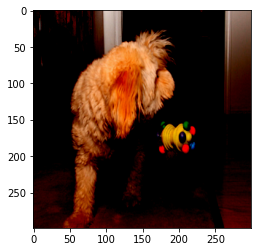

In [39]:
data = next(iter(dataloader))
plt.imshow(data['image'][0].permute(1,2,0))
model.caption_image(data['image'][0].to(device).unsqueeze(0))